# Google Analytics EDA + Baseline Model¶

In [1]:
import pickle
#Import Section
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import matplotlib & seaborn for visualisation
import json
from pandas.io.json import json_normalize
import seaborn as sns 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import numpy as np
init_notebook_mode(connected=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import missingno as msno
import collections

In [2]:
def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        #print(k,v)
        new_key = str(parent_key) + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [3]:
def flatten_main(d, parent_key='', sep='_'):
    items = {}
    for k, v in d.items():
        items[k]=flatten(v)
    return items

In [4]:
with open('ga_data.pickle', 'rb') as f:
    data_new = pickle.load(f)[:].to_dict('index')

 for k, v in data_new.items():
        for k1,v1 in v.items():
            if k1=='hits' and len(v1)>1:
                print(len(v1))
                print(v['totals'])

In [5]:
data_new_1=flatten_main(data_new)
data_new=pd.DataFrame.from_dict(data_new_1, orient='index')

In [6]:
sum(data_new['visitNumber']==1)

56553

In [7]:
msk = np.random.rand(len(data_new)) < 0.8
train = data_new[msk]
test = data_new[~msk]

In [8]:
train.head()

,visitorId,visitNumber,visitId,visitStartTime,date,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_bounces,...,geoNetwork_longitude,geoNetwork_networkLocation,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType,trafficSource_adwordsClickInfo_targetingCriteria_boomUserlistId
0,None,1,1500126674,1500126674,20170715,1,1,1.0,NaN,1.0,...,not available in demo dataset,not available in demo dataset,[],"[{'hitNumber': 1, 'time': 0, 'hour': 6, 'minut...",6790377449422493910,None,None,Organic Search,Not Socially Engaged,NaN
1,None,1,1500143533,1500143533,20170715,1,1,1.0,NaN,1.0,...,not available in demo dataset,not available in demo dataset,"[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 11, 'minu...",1431348163667504299,None,None,Organic Search,Not Socially Engaged,NaN
2,None,1,1500123204,1500123204,20170715,1,1,1.0,NaN,1.0,...,not available in demo dataset,not available in demo dataset,"[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",5628749752915535966,None,None,Organic Search,Not Socially Engaged,NaN
3,None,1,1500120750,1500120750,20170715,1,1,1.0,NaN,1.0,...,not available in demo dataset,not available in demo dataset,"[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",7721996906492012430,None,None,Organic Search,Not Socially Engaged,NaN
4,None,1,1500156541,1500156541,20170715,1,1,1.0,NaN,1.0,...,not available in demo dataset,not available in demo dataset,"[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 15, 'minu...",2699850580029059099,None,None,Direct,Not Socially Engaged,NaN


In [9]:
print(train.info(),test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59481 entries, 0 to 74367
Data columns (total 74 columns):
visitorId                                                          0 non-null object
visitNumber                                                        59481 non-null int64
visitId                                                            59481 non-null int64
visitStartTime                                                     59481 non-null int64
date                                                               59481 non-null object
totals_visits                                                      59481 non-null int64
totals_hits                                                        59481 non-null int64
totals_pageviews                                                   59469 non-null float64
totals_timeOnSite                                                  29301 non-null float64
totals_bounces                                                     30068 non-null float64
totals_

In [10]:
print(train.shape,test.shape)

(59481, 74) (14887, 74)


In [11]:
numeric_features_train = train.select_dtypes(include=[np.number])
numeric_features_train.columns

Index(['visitNumber', 'visitId', 'visitStartTime', 'totals_visits',
       'totals_hits', 'totals_pageviews', 'totals_timeOnSite',
       'totals_bounces', 'totals_transactions', 'totals_transactionRevenue',
       'totals_newVisits', 'totals_totalTransactionRevenue',
       'totals_sessionQualityDim', 'trafficSource_adwordsClickInfo_page',
       'trafficSource_adwordsClickInfo_targetingCriteria',
       'trafficSource_adwordsClickInfo_targetingCriteria_boomUserlistId'],
      dtype='object')

In [12]:
categorical_features_train = train.select_dtypes(include=[np.object])
categorical_features_train.columns

Index(['visitorId', 'date', 'totals_screenviews', 'totals_uniqueScreenviews',
       'totals_timeOnScreen', 'trafficSource_referralPath',
       'trafficSource_campaign', 'trafficSource_source',
       'trafficSource_medium', 'trafficSource_keyword',
       'trafficSource_adContent', 'trafficSource_adwordsClickInfo_campaignId',
       'trafficSource_adwordsClickInfo_adGroupId',
       'trafficSource_adwordsClickInfo_creativeId',
       'trafficSource_adwordsClickInfo_criteriaId',
       'trafficSource_adwordsClickInfo_slot',
       'trafficSource_adwordsClickInfo_criteriaParameters',
       'trafficSource_adwordsClickInfo_gclId',
       'trafficSource_adwordsClickInfo_customerId',
       'trafficSource_adwordsClickInfo_adNetworkType',
       'trafficSource_adwordsClickInfo_isVideoAd',
       'trafficSource_isTrueDirect', 'trafficSource_campaignCode',
       'device_browser', 'device_browserVersion', 'device_browserSize',
       'device_operatingSystem', 'device_operatingSystemVersion',

In [13]:
len(categorical_features_train.columns)

57

In [14]:
numeric_features_test = test.select_dtypes(include=[np.number])
categorical_features_test = test.select_dtypes(include=[np.object])

In [15]:
total_test = categorical_features_train.isnull().sum().sort_values(ascending=False)
percent = (categorical_features_train.isnull().sum()/categorical_features_train.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total_test, percent], axis=1,join='outer', keys=['Total Missing Count', ' % of Total Observations'])
missing_data.index.name ='Feature'
#missing_data.head(14)

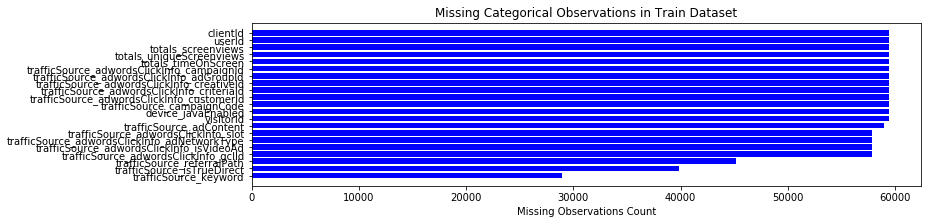

In [16]:
missing_values = categorical_features_train.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')
ind = np.arange(missing_values.shape[0])
width = 0.1
fig, ax = plt.subplots(figsize=(12,3))
rects = ax.barh(ind, missing_values.missing_count.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Observations Count")
ax.set_title("Missing Categorical Observations in Train Dataset")
plt.show()

In [17]:
total_test = categorical_features_test.isnull().sum().sort_values(ascending=False)
percent = (categorical_features_test.isnull().sum()/categorical_features_test.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total_test, percent], axis=1,join='outer', keys=['Total Missing Count', ' % of Total Observations'])
missing_data.index.name ='Feature'
#missing_data.head(12)

In [18]:
del train['hits']
del train['customDimensions']
del test['hits']
del test['customDimensions']

In [19]:
def Remove_Null_Columns(df):
    #dff = pd.DataFrame()
    for cl in df.select_dtypes(include=[np.object]):
        if df[cl].isnull().sum() == len(df[cl]):
            #pass 
            del df[cl]
        else:
            #dff[cl] = df[cl]
            pass
    return df

print ("Before removing constant columns - shape of train & test datasets: ", train.shape,test.shape)

train=Remove_Null_Columns(train)
test=Remove_Null_Columns(test)

print ("After Removing Constant Columns - shape of train & test datasets: ", train.shape,test.shape)

Before removing constant columns - shape of train & test datasets:  (59481, 72) (14887, 72)
After Removing Constant Columns - shape of train & test datasets:  (59481, 59) (14887, 59)


In [20]:
categorical_features_train_final = train.select_dtypes(include=[np.object])
len(categorical_features_train_final.columns)

42

In [21]:
colorscale = [[0, 'rgb(102,194,165)'], [0.0005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = train["geoNetwork_country"].value_counts().index,
        locationmode = 'country names',
        z = train["geoNetwork_country"].value_counts().values,
        marker = dict(
            line = dict(color = 'rgb(250,250,225)', width = 1)),
            colorbar = dict( title = 'Customer Visits ')
            ) 
       ]

layout = dict(
    height=600,
    title = 'World Wide Customer Visit Distribution',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = 'rgb(28,107,160)',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 50,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

In [22]:
layout = dict(
    height=600,
    title = 'World Wide Customer Visit Distribution',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = 'rgb(28,107,160)',
        projection = dict(
        type = 'conic equal area',
            rotation = dict(
                    lon = 50,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

In [23]:


geo_cols = ["geoNetwork_city", "geoNetwork_country", "geoNetwork_subContinent", "geoNetwork_continent"]
colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
traces = []
for i, col in enumerate(geo_cols):
    t = train[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15], x = t.values[:15]))

fig = tools.make_subplots(rows=2, cols=2, 
                          subplot_titles=["Visits: City", "Visits: Country","Visits: Sub Continent","Visits: Continent"]
                          , print_grid=False)
fig.append_trace(traces[0], 1, 1)
fig.append_trace(traces[1], 1, 2)
fig.append_trace(traces[2], 2, 1)
fig.append_trace(traces[3], 2, 2)

fig['layout'].update(height=600,width=1000, showlegend=False)
iplot(fig)

train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=["Mean Revenue by City", "Mean Revenue by Country","Mean Revenue by Sub Continent","Mean Revenue by Continent"], print_grid=False)

colors = ["red", "green", "purple","blue"]
trs = []
for i, col in enumerate(geo_cols):
    tmp = train.groupby(col).agg({"totals_transactionRevenue": "mean"}).reset_index().rename(columns={"totals_transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna()
    tr = go.Bar(x = tmp["Mean Revenue"], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig.append_trace(trs[2], 2, 1)
fig.append_trace(trs[3], 2, 2)

fig['layout'].update(height=600,width=1000, showlegend=False)
iplot(fig)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [24]:
t = train['channelGrouping'].value_counts()
values1 = t.values 
index1 = t.index
domain1 = {'x': [0.2, 0.50], 'y': [0.0, 0.33]}
fig = {
  "data": [
    {
      "values": values1,
      "labels": index1,
      "domain": {"x": [0, .48]},
    "marker" : dict(colors=["#f77b9c" ,'#ab97db',  '#b0b1b2']),
      "name": "Channel Grouping",
      "hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    }
   ],
  "layout": {"title":"Channel Grouping",
      "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Channel Grouping",
                "x": 0.11,
                "y": 0.5
            }
        ]
    }
}
iplot(fig)

In [25]:


fig = tools.make_subplots(rows=1, cols=2,subplot_titles=["Traffic Source Campaign (not-set removed)", "Traffic Source Medium"], print_grid=False)
 
colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
t1 = train["trafficSource_campaign"].value_counts()
t2 = train["trafficSource_medium"].value_counts()

tr1 = go.Bar(x = t1.index, y = t1.values, marker=dict(color=colors[1]))
tr2 = go.Bar(x = t2.index, y = t2.values, marker=dict(color=colors[2]))

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)


fig['layout'].update(height=400, margin=dict(b=100), showlegend=False)
iplot(fig)



In [26]:
def add_date_features(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    
    df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    return df

In [27]:
train = add_date_features(train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

In [28]:
# Visualization for Visits by date
tmp = train['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp = tmp.rename(columns = {"index" : "dateX", "date" : "visits"})

tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["visits"])
layout = go.Layout(title="Visits by Date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)
# Visualization for Visits by monthly revenue
tmp = train.groupby("date").agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp = tmp.rename(columns = {"date" : "dateX", "totals_transactionRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["mean_revenue"])
layout = go.Layout(title="Monthly Revenue by Date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)

In [29]:


fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits by Month", "Visits by Month Day", "Visits by Week Day"], print_grid=False)
trs = []
for i,col in enumerate(["month", "day", "weekday"]):
    t = train[col].value_counts()
    tr = go.Bar(x = t.index, marker=dict(color=colors[i]), y = t.values)
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)



In [30]:


tmp1 = train.groupby('month').agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp2 = train.groupby('day').agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp3 = train.groupby('weekday').agg({"totals_transactionRevenue" : "mean"}).reset_index()

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["MeanRevenue by Month", "MeanRevenue by MonthDay", "MeanRevenue by WeekDay"], print_grid=False)
tr1 = go.Bar(x = tmp1.month, marker=dict(color="yellow", opacity=0.5), y = tmp1.totals_transactionRevenue)
tr2 = go.Bar(x = tmp2.day, marker=dict(color="blue", opacity=0.5), y = tmp2.totals_transactionRevenue)
tr3 = go.Bar(x = tmp3.weekday, marker=dict(color="violet", opacity=0.5), y = tmp3.totals_transactionRevenue)

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig.append_trace(tr3, 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)



In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

agg_dict = {}
for col in ["totals_bounces", "totals_hits", "totals_newVisits", "totals_pageviews", "totals_transactionRevenue"]:
    train[col] = train[col].astype('float')
    agg_dict[col] = "sum"
tmp = train.groupby("fullVisitorId").agg(agg_dict).reset_index()
tmp.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,fullVisitorId,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue
0,0000062267706107999,1.0,1.0,1.0,1.0,0.0
1,0000085059828173212,1.0,1.0,1.0,1.0,0.0
2,0000436683523507380,0.0,8.0,0.0,8.0,0.0
3,0000450371054833295,1.0,1.0,1.0,1.0,0.0
4,0000884932399915132,0.0,9.0,1.0,8.0,0.0


In [32]:
non_zero = tmp[tmp["totals_transactionRevenue"] > 0]["totals_transactionRevenue"]
print ("There are " + str(len(non_zero)) + " visitors in the train dataset having non zero total transaction revenue")
non_zero.head()

There are 823 visitors in the train dataset having non zero total transaction revenue


57       2390000.0
72      33170000.0
134    126890000.0
252     43160000.0
516     44200000.0
Name: totals_transactionRevenue, dtype: float64

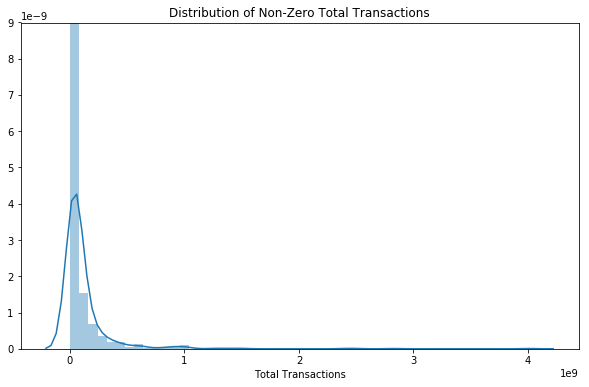

In [33]:
plt.figure(figsize=(10,6))
sns.distplot(non_zero)
plt.title("Distribution of Non-Zero Total Transactions");
plt.xlabel("Total Transactions");

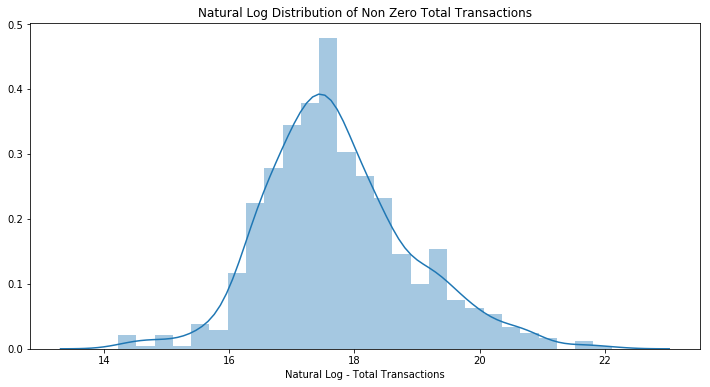

In [34]:
plt.figure(figsize=(12,6))
sns.distplot(np.log1p(non_zero))
plt.title("Natural Log Distribution of Non Zero Total Transactions");
plt.xlabel("Natural Log - Total Transactions");



In [35]:
## find constant columns
constant_columns = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        constant_columns.append(col)

## non relevant columns
non_relevant = ["visitNumber", "date", "fullVisitorId", "sessionId", "visitId", "visitStartTime"]

In [36]:
constant_columns

['totals_visits',
 'totals_bounces',
 'totals_newVisits',
 'trafficSource_adwordsClickInfo_criteriaParameters',
 'trafficSource_adwordsClickInfo_adNetworkType',
 'trafficSource_adwordsClickInfo_isVideoAd',
 'trafficSource_isTrueDirect',
 'device_browserVersion',
 'device_browserSize',
 'device_operatingSystemVersion',
 'device_mobileDeviceBranding',
 'device_mobileDeviceModel',
 'device_mobileInputSelector',
 'device_mobileDeviceInfo',
 'device_mobileDeviceMarketingName',
 'device_flashVersion',
 'device_language',
 'device_screenColors',
 'device_screenResolution',
 'geoNetwork_cityId',
 'geoNetwork_latitude',
 'geoNetwork_longitude',
 'geoNetwork_networkLocation',
 'socialEngagementType']

In [37]:
test = add_date_features(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

In [38]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = [c for c in train.columns if not c.startswith("total")]
categorical_columns = [c for c in categorical_columns if c not in constant_columns + non_relevant]
for c in categorical_columns:

    le = LabelEncoder()
    train_vals = list(train[c].values.astype(str))
    test_vals = list(test[c].values.astype(str))
    
    le.fit(train_vals + test_vals)
    
    train[c] = le.transform(train_vals)
    test[c] = le.transform(test_vals)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [39]:
def normalize_numerical_columns(df, isTrain = True):
    df["totals_hits"] = df["totals_hits"].astype(float)
    df["totals_hits"] = (df["totals_hits"] - min(df["totals_hits"])) / (max(df["totals_hits"]) - min(df["totals_hits"]))

    df["totals_pageviews"] = df["totals_pageviews"].astype(float)
    df["totals_pageviews"] = (df["totals_pageviews"] - min(df["totals_pageviews"])) / (max(df["totals_pageviews"]) - min(df["totals_pageviews"]))
    
    if isTrain:
        df["totals_transactionRevenue"] = df["totals_transactionRevenue"].fillna(0.0)
    return df

In [40]:
train = normalize_numerical_columns(train)
test = normalize_numerical_columns(test, isTrain = False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

In [41]:
train.to_csv('ana_train.csv', index=False)
test.to_csv('ana_test.csv', index=False)

In [85]:
from sklearn.model_selection import train_test_split
features = [c for c in train.columns if c not in constant_columns + non_relevant]
features.remove("totals_transactionRevenue")
train["totals_transactionRevenue"] = np.log1p(train["totals_transactionRevenue"].astype(float))
train_x, valid_x, train_y, valid_y = train_test_split(train[features], train["totals_transactionRevenue"], test_size=0.25, random_state=20)

In [91]:
import lightgbm as lgb 

lgb_params = {"objective" : "regression", "metric" : "rmse",
              "num_leaves" : 50, "learning_rate" : 0.02, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9}
    
lgb_train = lgb.Dataset(train_x, label=train_y)
lgb_val = lgb.Dataset(valid_x, label=valid_y)
model = lgb.train(lgb_params, lgb_train, 400, valid_sets=[lgb_val], early_stopping_rounds=150, verbose_eval=20)

Training until validation scores don't improve for 150 rounds
[20]	valid_0's rmse: 1.48379
[40]	valid_0's rmse: 0.992361
[60]	valid_0's rmse: 0.664829
[80]	valid_0's rmse: 0.453132
[100]	valid_0's rmse: 0.306242
[120]	valid_0's rmse: 0.212091
[140]	valid_0's rmse: 0.147863
[160]	valid_0's rmse: 0.106589
[180]	valid_0's rmse: 0.0807068
[200]	valid_0's rmse: 0.0656629
[220]	valid_0's rmse: 0.0571665
[240]	valid_0's rmse: 0.0519519
[260]	valid_0's rmse: 0.0490951
[280]	valid_0's rmse: 0.04753
[300]	valid_0's rmse: 0.0465794
[320]	valid_0's rmse: 0.0461518
[340]	valid_0's rmse: 0.0459067
[360]	valid_0's rmse: 0.0457802
[380]	valid_0's rmse: 0.0456968
[400]	valid_0's rmse: 0.0456597
Did not meet early stopping. Best iteration is:
[400]	valid_0's rmse: 0.0456597


In [92]:
preds = model.predict(test[features], num_iteration=model.best_iteration)
test["PredictedLogRevenue"] = np.expm1(preds)
submission = test.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()
submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] =  submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission.to_csv("baseline.csv", index=False)
submission.head()

,fullVisitorId,PredictedLogRevenue
0,0000085059828173212,0.000112
1,0000436683523507380,0.000000
2,000170187170673177,0.000112
3,0001726271671346816,0.000112
4,0002457163364254438,0.002660
